In [1]:
import sys
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import epitopepredict as ep
from epitopepredict import base, sequtils, analysis, plotting
from mhcflurry import Class1AffinityPredictor

This code is used to load the csv files containing the predictions for peptides binding affinities obtained with netMHCflurry and netMHCpan4.0 and then filter the results comparing the two methods. The present code is applied to SARS-CoV-2 data.

In [2]:
#load dataframes
df1=pd.read_csv("../Data/df_netMHCflurry-covid_all-allele.csv")
df2=pd.read_csv("../Data/df_netMHCpan-all_alleles_covid.csv")

In [3]:
# take only columns of interest
df22=df2[["Peptide","allele","nM"]]

In [4]:
# take only columns of interest
df11=df1[["peptide","allele","prediction"]]

In [5]:
# Make column name uniform
df22=df22.rename(columns={"Peptide": "peptide", "allele": "allele", "nM": "prediction"})
df22=df22.rename(columns={"prediction":"prediction2"})

In [6]:
#sort columns
df22=df22.sort_values(by=['peptide','allele'])
df11=df11.sort_values(by=['peptide','allele'])

In [7]:
# merge the two dataframes
dfp=pd.merge(left=df11,right=df22)

<Figure size 432x288 with 0 Axes>

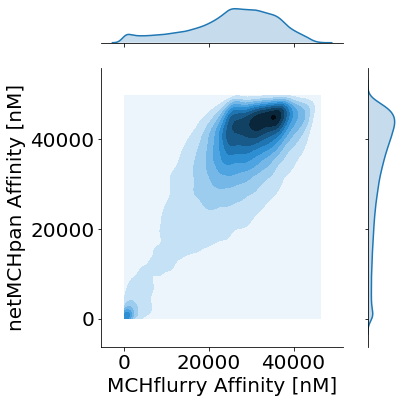

In [8]:
#Create jointplots for the predictions of the two methods. 
%matplotlib inline
plt.clf()
plt.rcParams.update({'font.size': 20})
ax=sns.jointplot(x="prediction",y="prediction2", data=dfp, kind="kde", cut=0)
ax.set_axis_labels('MCHflurry Affinity [nM]', 'netMCHpan Affinity [nM]', fontsize=20)
ax = plt.gcf()
plt.tight_layout()
plt.savefig("../FIGURES/jointplot-dp.png", dpi=150)

In [9]:
# Filter the results of the two methods
dfp["deltap"]=np.abs(dfp["prediction"]-dfp["prediction2"])/(dfp["prediction"]+dfp["prediction2"])
dfp_cut=dfp[(dfp["deltap"]<.25)].copy()

In [10]:
dfp_cut["K_tot"]=2./(dfp_cut["prediction"]+dfp_cut["prediction2"])

The following lines of codes are devoted to compute the total Binding affinity and plot the results for each allele

In [11]:
#Compute total affinity for each allele
results4_HLA=dfp_cut.groupby(["allele"],as_index=False).sum()
results4_HLA["EC50"]=1./results4_HLA["K_tot"]

In [12]:
# divide df in HLA-A,B,C and sort
HLAA4=results4_HLA[results4_HLA["allele"].str.contains("HLA-A")]
HLAB4=results4_HLA[results4_HLA["allele"].str.contains("HLA-B")]
HLAC4=results4_HLA[results4_HLA["allele"].str.contains("HLA-C")]
HLAA4=HLAA4.sort_values("EC50",ascending=False)
HLAB4=HLAB4.sort_values("EC50",ascending=False)
HLAC4=HLAC4.sort_values("EC50",ascending=False)

In [13]:
HLAA4=HLAA4.reset_index(drop=True)
HLAB4=HLAB4.reset_index(drop=True)
HLAC4=HLAC4.reset_index(drop=True)

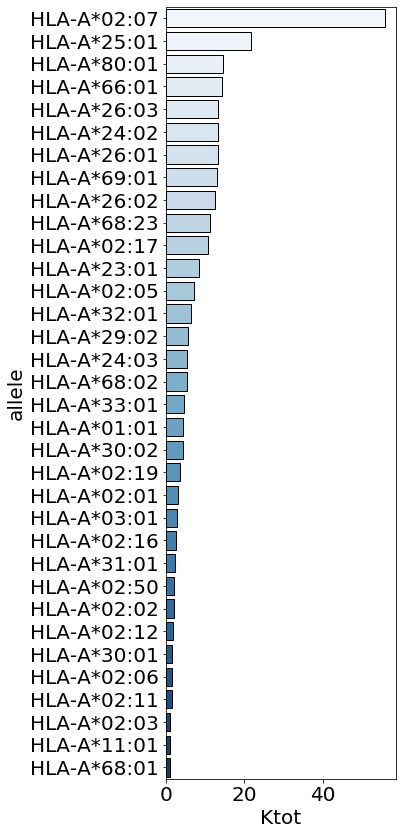

In [14]:
# plot the total affinities for HLA-A
%matplotlib inline
plt.clf()
plt.rcParams.update({'font.size': 20})
ax=sns.barplot(data=HLAA4,x="EC50",y="allele", palette='Blues', linewidth=1, edgecolor="0")
ax.set_xlabel("Ktot")
ax = plt.gcf()
ax.set_size_inches(6, 12)
plt.tight_layout()
#plt.savefig("../Figures/boxplotHLA-A_EC50-filter-dp-we.png", dpi=150)

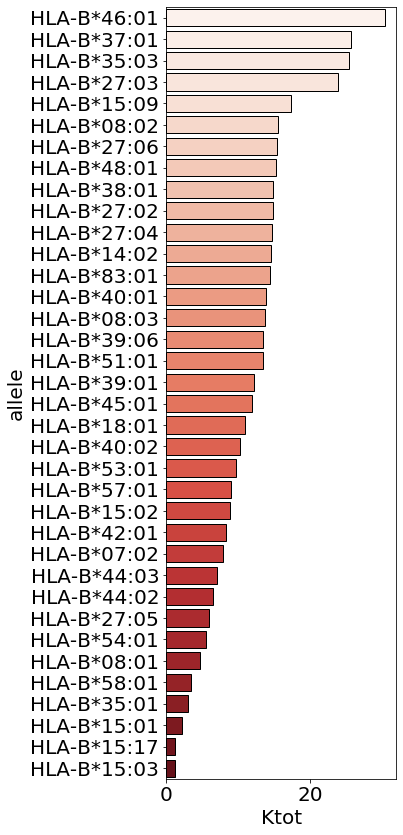

In [15]:
# plot the total affinities for HLA-A
%matplotlib inline
plt.clf()
plt.rcParams.update({'font.size': 20})
ax=sns.barplot(data=HLAB4,x="EC50",y="allele", palette='Reds', linewidth=1, edgecolor="0")
ax.set_xlabel("Ktot")
ax = plt.gcf()
ax.set_size_inches(6, 12)
plt.tight_layout()
#plt.savefig("../Figures/boxplotHLA-B_EC50-filter-dp-we.png", dpi=150)

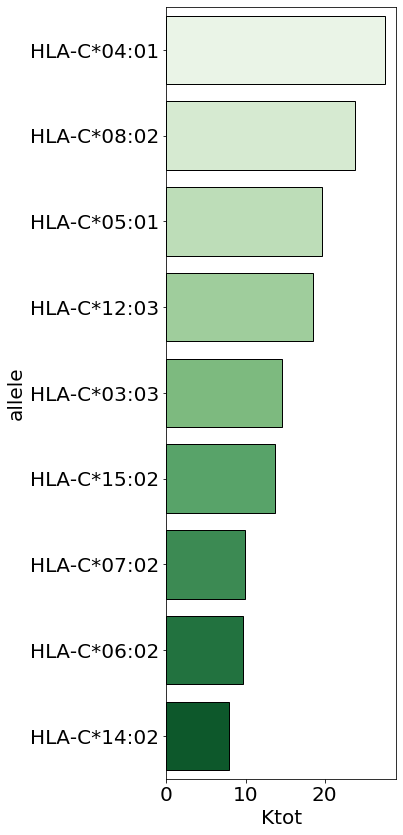

In [16]:
# plot the total affinities for HLA-C
%matplotlib inline
plt.clf()
plt.rcParams.update({'font.size': 20})
ax=sns.barplot(data=HLAC4,x="EC50",y="allele", palette='Greens', linewidth=1, edgecolor="0")
ax.set_xlabel("Ktot")
ax = plt.gcf()
ax.set_size_inches(6, 12)
plt.tight_layout()
#plt.savefig("../Figures/boxplotHLA-C_EC50-filter-dp-we.png", dpi=150)

The following code lines are devoted to compure distributions of binding affinities

In [17]:
#prepare data for distributions
HLAA=dfp_cut[dfp_cut["allele"].str.contains("HLA-A")].copy()
HLAB=dfp_cut[dfp_cut["allele"].str.contains("HLA-B")].copy()
HLAC=dfp_cut[dfp_cut["allele"].str.contains("HLA-C")].copy()
HLAA["affinity"]=1./HLAA["K_tot"]
HLAB["affinity"]=1./HLAB["K_tot"]
HLAC["affinity"]=1./HLAC["K_tot"]
HLAA=HLAA.sort_values(by="allele")
HLAB=HLAB.sort_values(by="allele")
HLAC=HLAC.sort_values(by="allele")

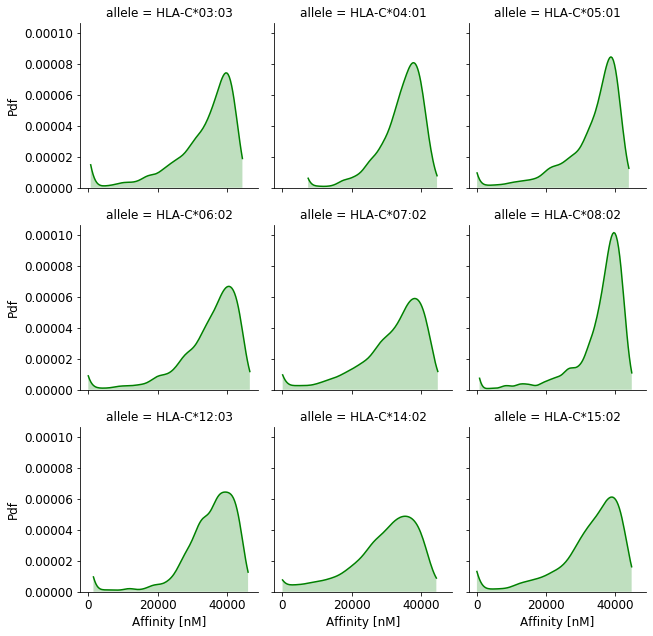

In [18]:
# Plot distributions of affinities HLA-C
plt.rcParams.update({'font.size': 12})
g = sns.FacetGrid(HLAC, col="allele", col_wrap=3)
g.map(sns.kdeplot, "affinity", color="green", cut=0, shade=True)
g.set_xlabels("Affinity [nM]")
g.set_ylabels("Pdf")
#plt.savefig("../FIGURES/histHLAC-filter-dp.png", dpi=150)

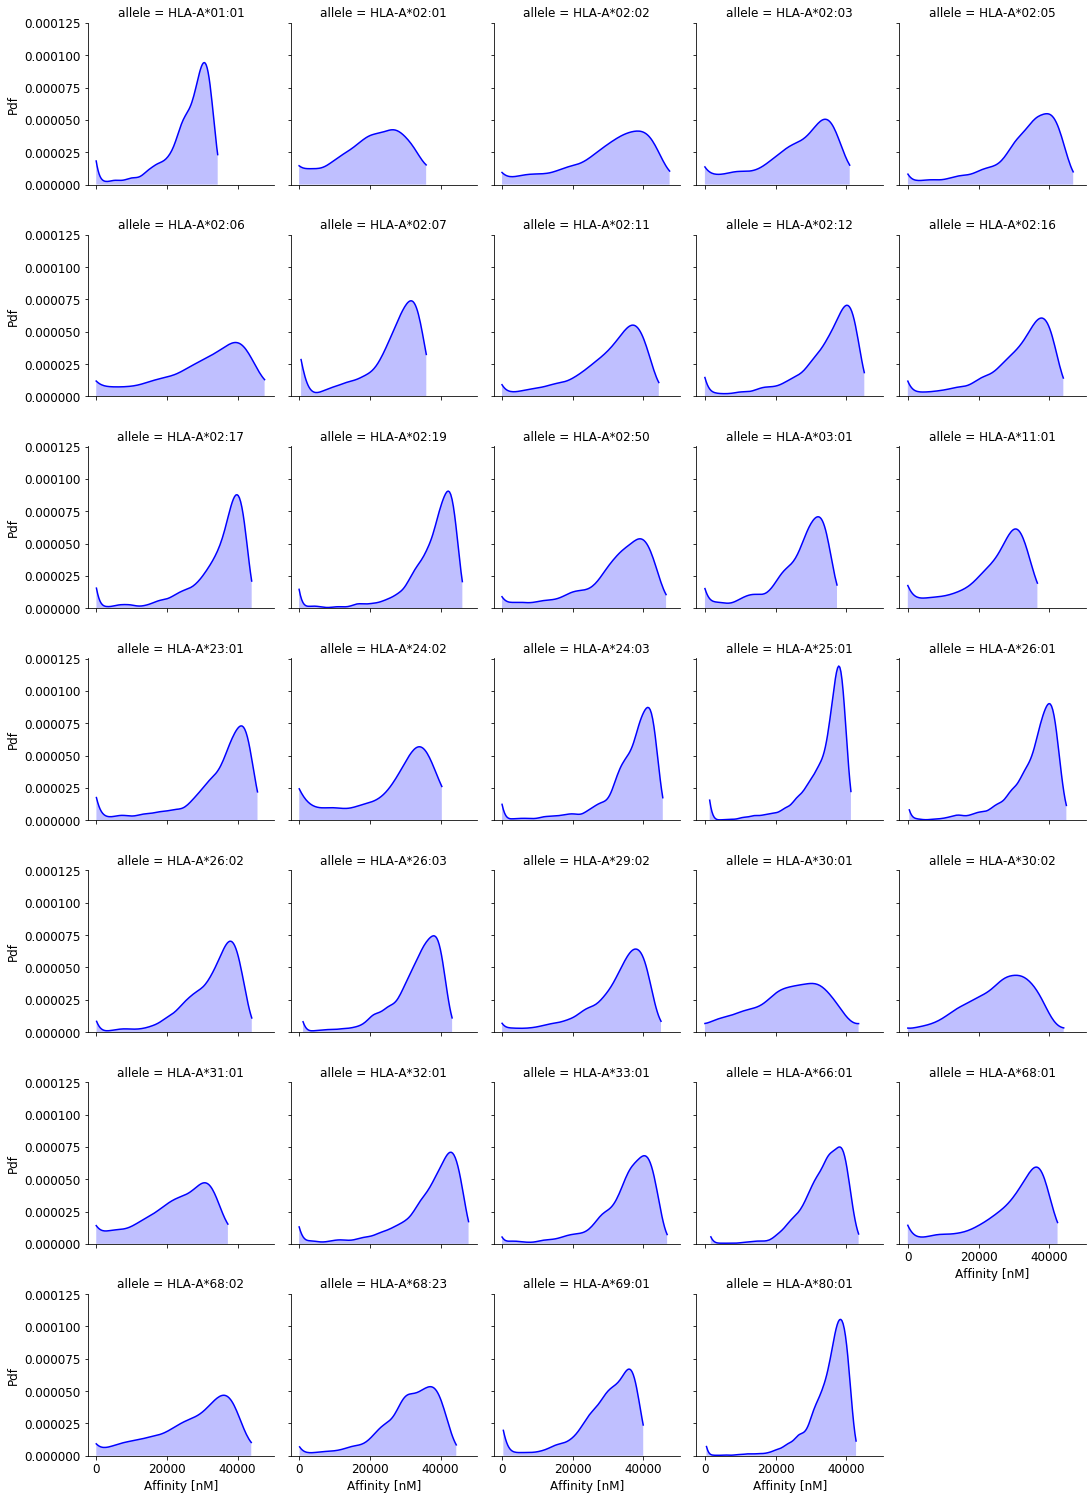

In [19]:
# Plot distributions of affinities HLA-A
plt.rcParams.update({'font.size': 12})
g = sns.FacetGrid(HLAA, col="allele", margin_titles=True, col_wrap=5)
g.map(sns.kdeplot, "affinity", color="blue", cut=0, shade=True)
g.set_xlabels("Affinity [nM]")
g.set_ylabels("Pdf")
#plt.savefig("../FIGURES/histHLAA-filter-dp.png", dpi=150)

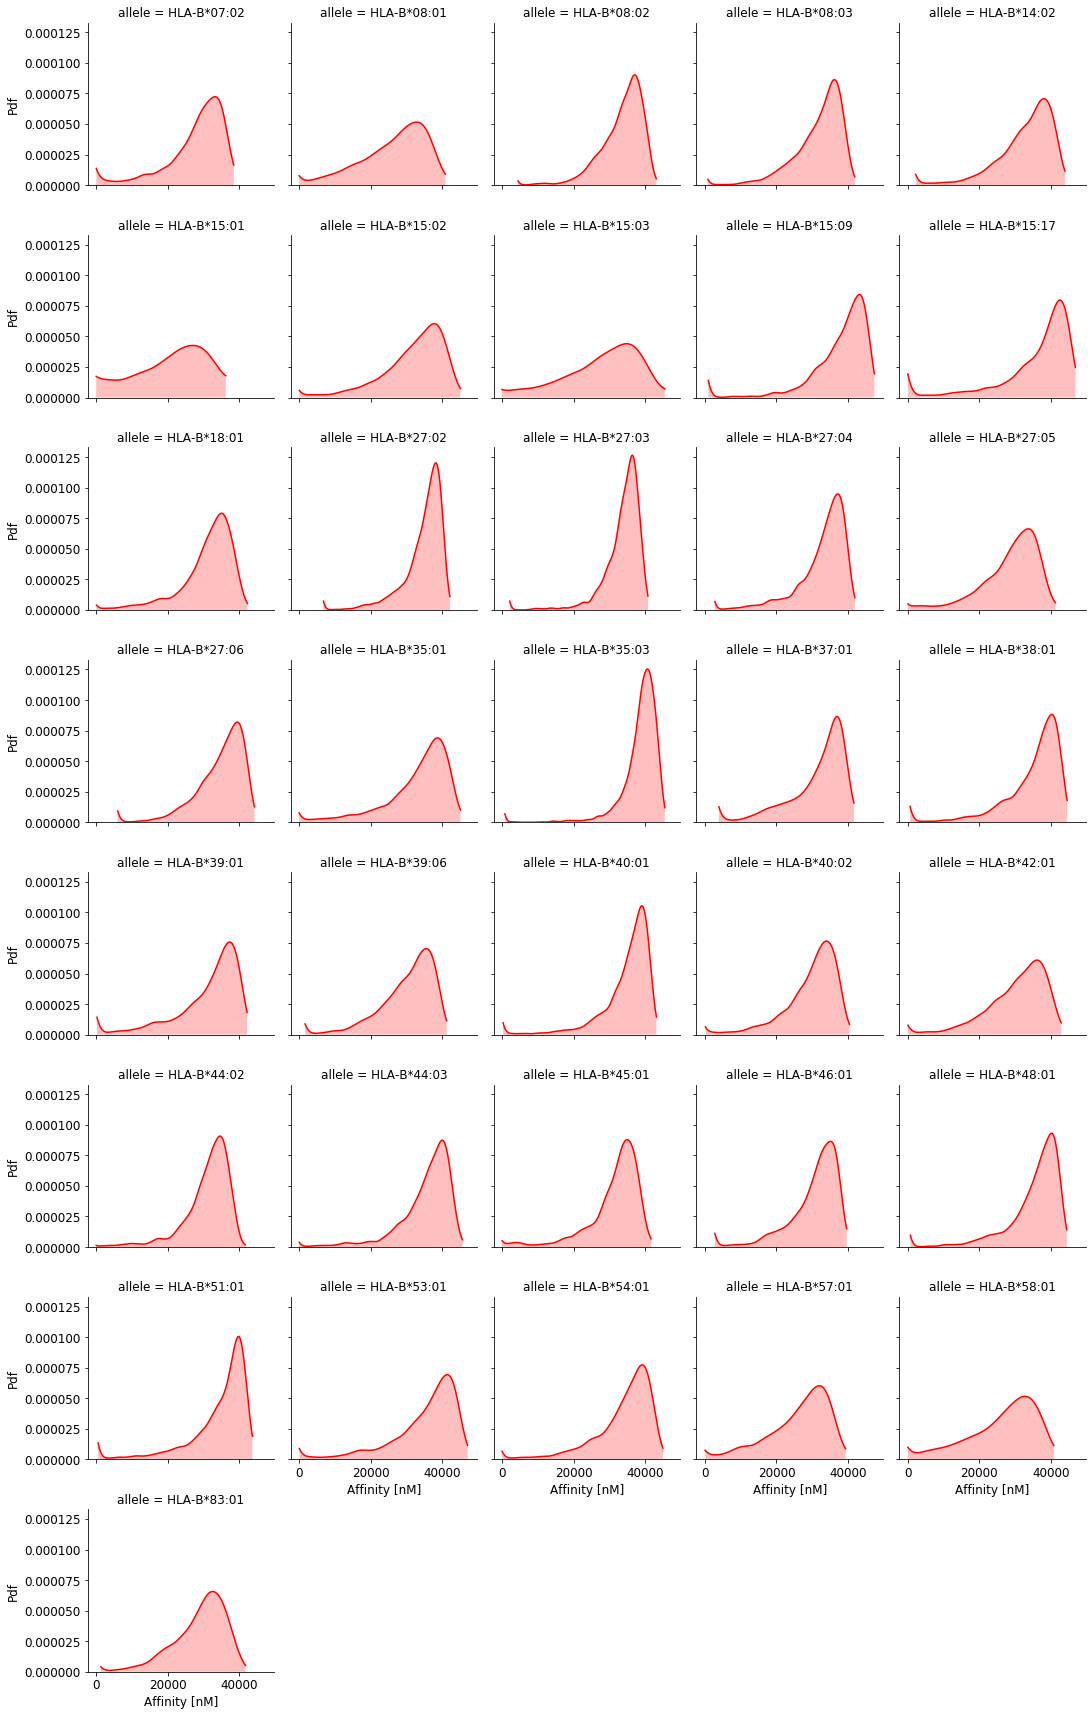

In [20]:
# Plot distributions of affinities HLA-B
plt.rcParams.update({'font.size': 12})
g = sns.FacetGrid(HLAB, col="allele", margin_titles=True, col_wrap=5)
g.map(sns.kdeplot, "affinity", color="red", cut=0, shade=True)
g.set_xlabels("Affinity [nM]")
g.set_ylabels("Pdf")
#plt.savefig("../FIGURES/histHLAB-filter-dp.png", dpi=150)

The following lines are devoted to identify and count strong binding peptides

In [48]:
# Define cutoff for strong binders
#cutoff=1000.
cutoff=500.
df_filter=dfp_cut[(dfp_cut["prediction"]<cutoff)&(dfp_cut["prediction2"]<cutoff)].copy()

In [49]:
# Count strongly binding peptides
results_count_HLA=df_filter.groupby(["allele"],as_index=False).count()
results_count_HLA=results_count_HLA[["allele","peptide"]]
all_alleles=results4_HLA[["allele","EC50"]]
counts=all_alleles.join(results_count_HLA.set_index('allele'), on='allele').fillna(0)

In [50]:
df_filter["IC50"]=1./df_filter["K_tot"]

In [42]:
# Divide df in HLA-A,B,C
HLAAcut=counts[counts["allele"].str.contains("HLA-A")]
HLABcut=counts[counts["allele"].str.contains("HLA-B")]
HLACcut=counts[counts["allele"].str.contains("HLA-C")]
HLAAcut=HLAAcut.sort_values("peptide")
HLABcut=HLABcut.sort_values("peptide")
HLACcut=HLACcut.sort_values("peptide")

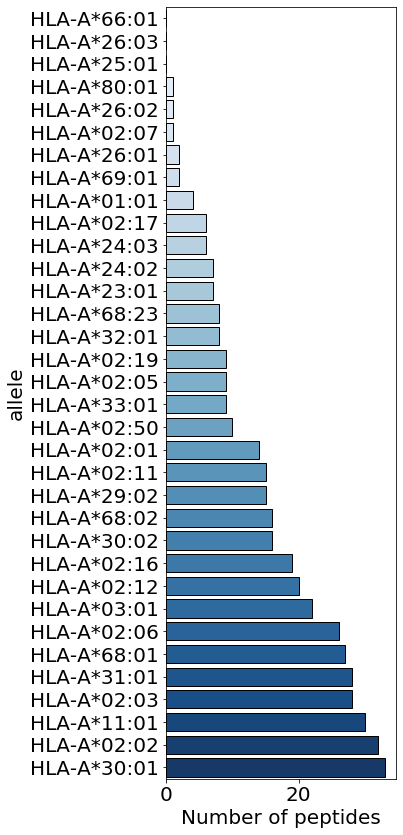

In [51]:
# Plot number of peptides
%matplotlib inline
plt.clf()
plt.rcParams.update({'font.size': 20})
ax=sns.barplot(data=HLAAcut,y="allele",x="peptide", palette='Blues', linewidth=1, edgecolor="0")
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("Number of peptides")
ax = plt.gcf()
ax.set_size_inches(6, 12)
#plt.ylim(0,10)
plt.tight_layout()
plt.savefig("../FIGURES/boxplotHLAA_N-cut500-both.png", dpi=150)

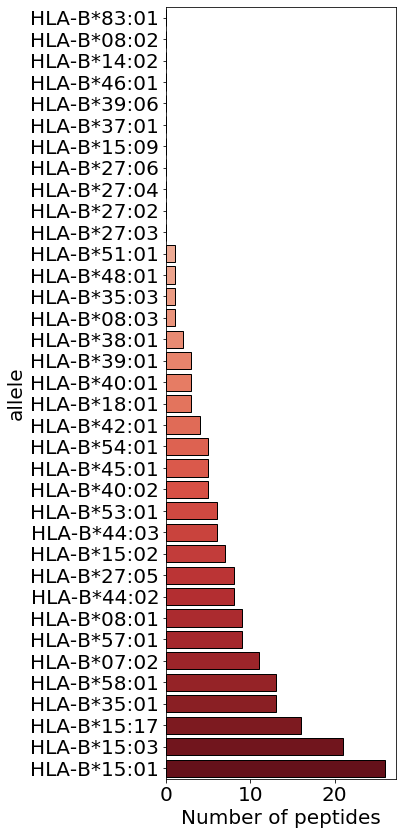

In [52]:
# Plot number of peptides
%matplotlib inline
plt.clf()
plt.rcParams.update({'font.size': 20})
ax=sns.barplot(data=HLABcut,y="allele",x="peptide", palette='Reds', linewidth=1, edgecolor="0")
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("Number of peptides")
ax = plt.gcf()
ax.set_size_inches(6, 12)
#plt.ylim(0,10)
plt.tight_layout()
plt.savefig("../FIGURES/boxplotHLAB_N-cut500-both.png", dpi=150)

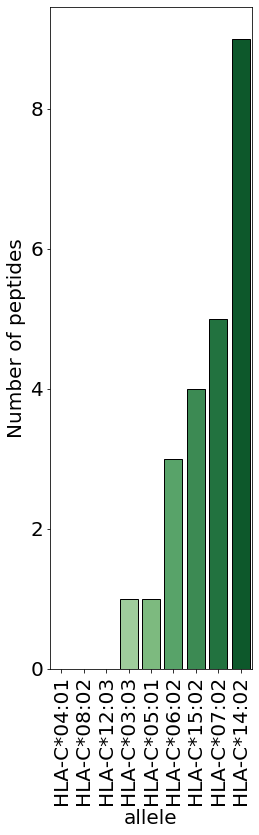

In [53]:
# Plot number of peptides
%matplotlib inline
plt.clf()
plt.rcParams.update({'font.size': 20})
ax=sns.barplot(data=HLACcut,x="allele",y="peptide", palette='Greens', linewidth=1, edgecolor="0")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("Number of peptides")
ax = plt.gcf()
ax.set_size_inches(4, 12)
#plt.ylim(0,10)
plt.tight_layout()
plt.savefig("../FIGURES/boxplotHLAC_N-cut500-both.png", dpi=150)

In [47]:
# Write summary data
counts["Virus"]="SARS-CoV-2"
counts.to_csv("../Data/Covid_summary_1000.csv")
df_filter.to_csv("../Data/COVID_peptides_1000.csv")
dfp_cut.to_csv("../Data/All_COVID_peptides.csv")

In [29]:
# Define list of weakly binding peptides
weaklist=counts[counts["peptide"]<1].copy()

In [30]:
weak=weaklist["allele"]

In [31]:
# Define list of strogly binding peptides
stronglist=counts[counts["peptide"]>15].copy()

In [32]:
strong=stronglist["allele"]

In [33]:
strong.to_csv("../Data/strong-allele-500.csv")

/Users/szapperi/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [34]:
weak.to_csv("../Data/weak-allele-500.csv")

/Users/szapperi/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
